# Density Estimator for scRNA-seq Data

This notebook provides a guide to applying the Mellon density estimator on single-cell RNA sequencing (scRNA-seq) data. The objective of this tutorial is to illustrate the steps needed to execute a density estimation using the Mellon package. By the end of this notebook, you should have a solid understanding of how to use Mellon in your data analysis.

Before we start, let's load all the necessary libraries.

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import palantir
import mellon
import scanpy as sc

We are also setting some plot preferences and suppressing the NumbaDeprecationWarning for a cleaner output.

In [2]:
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = [4, 4]
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["image.cmap"] = "Spectral_r"
# no bounding boxes or axis:
matplotlib.rcParams["axes.spines.bottom"] = "off"
matplotlib.rcParams["axes.spines.top"] = "off"
matplotlib.rcParams["axes.spines.left"] = "off"
matplotlib.rcParams["axes.spines.right"] = "off"

import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

## Step 1: Loading the Data

We will start by loading the scRNA-seq dataset. For this demonstration, we will use a publicly available dataset of T-cell depleted bone marrow.

In [3]:
ad_url = "https://zenodo.org/record/6383269/files/bm_multiome_rna.h5ad"
ad = sc.read("data/bm_multiome_rna.h5ad", backup_url=ad_url)

Note: The annData object `ad` we loaded already has been processed from raw gene counts according to the following [notebook](https://github.com/settylab/single-cell-primers/blob/main/notebooks/PBMC-RNA-standalone.ipynb), and comes with cell-type annotations, PCA, and a UMAP representation.

## Step 2: Preprocessing

Even though our data is preprocessed, we will further use a diffusion map representation to clean up the cell-state representation. The diffusion map captures the intrinsic geometry of the data by creating a reduced dimensional representation that maintains the relationships between cells.

In [4]:
dm_res = palantir.utils.run_diffusion_maps(
    pd.DataFrame(ad.obsm["X_pca"], index=ad.obs_names),
)
ad.obsp["DM_Kernel"] = dm_res["kernel"]
ad.obsm["DM_EigenVectors"] = dm_res["EigenVectors"].values
ad.uns["DMEigenValues"] = dm_res["EigenValues"].values

Determing nearest neighbor graph...


## Step 3: Compute Pseudotime (optional)

Pseudotime computation is not required for the density computation, but it can be insightful to investigate cell-state density fluctuation along temporal trajectories such as cell differentiation.

We will identify an 'early' cell based on diffusion components. The cell with the maximum or minimum value for any component and is a Hematopoietic Stem and Progenitor Cell (HSPC) is selected as an early cell. This cell is expected to have the least differentiated state in the dataset.


In [5]:
celltype = "HSPC"
for dcomp in range(ad.obsm["DM_EigenVectors"].shape[1]):
    ec = ad.obsm["DM_EigenVectors"][:, dcomp].argmax()
    if ad.obs["celltype"][ec] == celltype:
        mm = "maximum"
        break
    ec = ad.obsm["DM_EigenVectors"][:, dcomp].argmin()
    if ad.obs["celltype"][ec] == celltype:
        mm = "minimum"
        break
else:  # no break
    raise Exception("No valid component found.")
early_cell = ad.obs_names[ec]
print(
    f"Using {early_cell} as early cell which is the {mm} of diffusion component {dcomp}."
)

Using IM-1393_BoneMarrow_TcellDep_2_multiome#AGCCGCTAGACAAGTG-1 as early cell which is the minimum of diffusion component 5.


After defining an early cell, we will run Palantir, which has a method for estimating a pseudo time which will help us to order the cells according to their developmental progression.

Sampling and flocking waypoints...
Time for determining waypoints: 0.013631685574849447 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.2757332921028137 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9998
Correlation at iteration 2: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


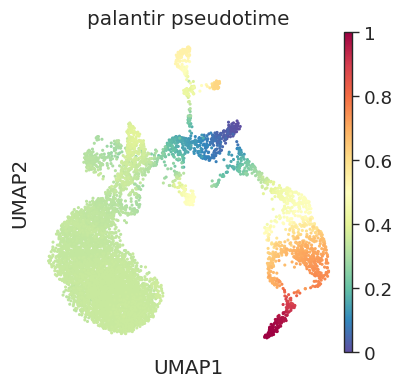

In [6]:
ms_data = palantir.utils.determine_multiscale_space(dm_res)
pl_res = palantir.core.run_palantir(ms_data, early_cell)
ad.obs["palantir_pseudotime"] = pl_res.pseudotime
sc.pl.scatter(ad, basis="umap", color=["palantir_pseudotime"], size=20)

## Step 4: Density Computation

Now we get to the key part of this tutorial - computing the density. We use the DensityEstimator class from the Mellon package to do this. We will then plot the computed log_density using the UMAP.

In [7]:
%%time
model = mellon.DensityEstimator()
log_density = model.fit_predict(ad.obsm["DM_EigenVectors"])
ad.obs["log_density"] = log_density
ad.obs["log_density_clipped"] = np.clip(
    log_density, *np.quantile(log_density, [0.05, 1])
)

[2023-05-22 01:22:44,120] [INFO    ] Computing nearest neighbor distances.
[2023-05-22 01:22:44,431] [INFO    ] Using covariance function Matern52(ls=0.002264451182505261).
[2023-05-22 01:22:44,432] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2023-05-22 01:22:47,314] [INFO    ] Doing low-rank Cholesky decomposition.
[2023-05-22 01:22:51,805] [INFO    ] Using rank 5,000 covariance representation.
[2023-05-22 01:22:52,746] [INFO    ] Running inference using L-BFGS-B.
CPU times: user 54.5 s, sys: 1min 38s, total: 2min 33s
Wall time: 19.7 s


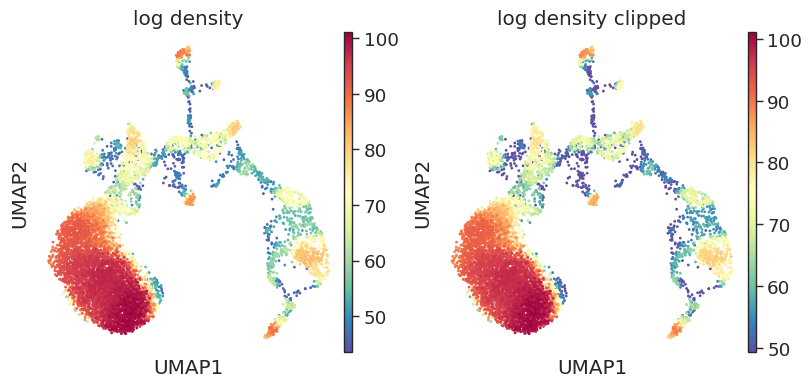

In [8]:
sc.pl.scatter(ad, color=["log_density", "log_density_clipped"], basis="umap")

## Step 5: Analysis

Next, we will use the calculated cell densities to analyze different cell types in the dataset. First, we'll plot violin plots of log density by cell type and a UMAP plot colored by cell type. Then, we will focus on a specific subset of cell types, plot their densities against pseudotime, and visualize them on UMAP.

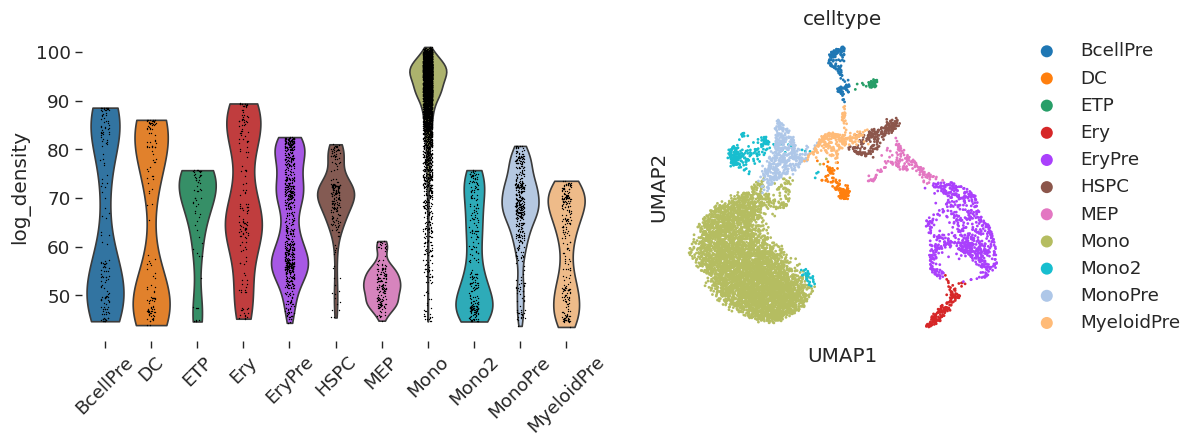

In [9]:
matplotlib.rcParams["figure.figsize"] = [12, 4]
fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[3, 2])
sc.pl.violin(ad, "log_density", "celltype", rotation=45, ax=ax1, show=False)
sc.pl.scatter(ad, color="celltype", basis="umap", ax=ax2, show=False)
plt.show()

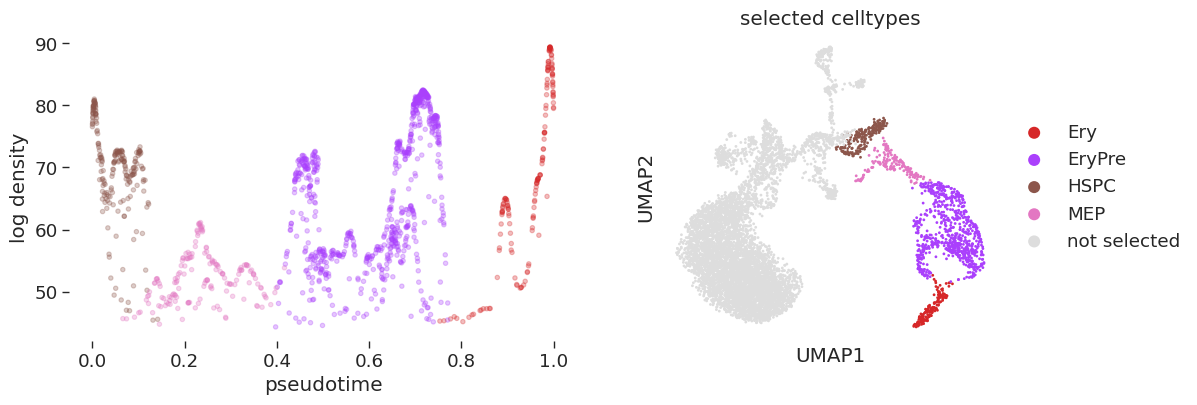

In [10]:
selection = ["HSPC", "MEP", "EryPre", "Ery"]

matplotlib.rcParams["figure.figsize"] = [12, 4]
fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[3, 2])

ct_colors = ad.uns.get(
    "ct_colors",
    dict(zip(ad.obs["celltype"].cat.categories, ad.uns["celltype_colors"])),
)
sct_colors = {ct: ct_colors[ct] for ct in selection}
sct_colors["not selected"] = "#DDDDDD"
idx = ad.obs["celltype"].isin(selection)
color_vec = [sct_colors[ct] for ct in ad.obs.loc[idx, "celltype"]]
ad.obs["selected_celltypes"] = (
    ad.obs["celltype"].astype(str).where(idx, "not selected").astype("category")
)
ad.uns["selected_celltypes_colors"] = [
    sct_colors[c] for c in ad.obs["selected_celltypes"].cat.categories
]
scatter = ax1.scatter(
    ad.obs.loc[idx, "palantir_pseudotime"],
    ad.obs.loc[idx, "log_density"],
    c=color_vec,
    s=10,
    alpha=0.3,
)
ax1.set_xlabel("pseudotime")
ax1.set_ylabel("log density")
sc.pl.scatter(ad, color="selected_celltypes", basis="umap", ax=ax2)
plt.show()

## Step 6: Serialization

After the analysis, we can save the predictive function `model.predict` in a serializable form into the AnnData, save the AnnData to disk, read it into memory, and reconstruct the predictor.

In [11]:
ad.uns["log_density_function"] = model.predict.to_dict()
# ad.write('adata.h5ad')
# ad = anndata.read('adata.h5ad')
predictor = mellon.Predictor.from_dict(ad.uns["log_density_function"])

# apply the predictor on any data
log_density = predictor(ad.obsm["DM_EigenVectors"])

if np.all(np.isclose(log_density, ad.obs["log_density"])):
    print("Deserialized density function is identical.")

[2023-05-22 01:23:04,599] [INFO    ] Computing predictive function.
Deserialized density function is identical.


# Adjustable parameters

Mellon provides a flexible and customizable approach to compute cell density with several adjustable parameters for fine-tuning the model according to the specific requirements of your dataset. Here, we will go through some of these parameters.

In [12]:
X = ad.obsm["DM_EigenVectors"]
nn_distances = mellon.compute_nn_distances(X)

The `length_scale` parameter determines the smoothness of the resulting density function. A lower value leads to a more detailed, but less stable, density function. By default, Mellon calculates the length scale based on a heuristic to maximize the posterior likelihood of the resulting density function.

In [13]:
length_scale = mellon.compute_ls(nn_distances)

Landmarks in the data are used to approximate the covariance structure and hence the similarity of density values between cells by using the similarity to the landmarks as proxy. K-means clustering centroids usually provide good landmarks. The number of landmarks limits the rank of the covariance matrix.

In [14]:
%%time
n_landmarks = 5000
landmarks = mellon.k_means(X, n_landmarks, n_init=1)[0]

CPU times: user 23.9 s, sys: 1min 18s, total: 1min 41s
Wall time: 2.85 s


You can further reduce the rank of the covariance matrix using an improved Nyström approximation. The `rank` parameter allows you to set either the fraction of total variance (sum of eigenvalues) preserved or a specific number of ranks.

In [15]:
%%time
rank = 0.999
cov_func = mellon.Matern52(length_scale)
L = mellon.compute_L(X, cov_func, landmarks=landmarks, rank=rank)

[2023-05-22 01:23:10,910] [INFO    ] Doing low-rank improved Nyström decomposition.
[2023-05-22 01:23:27,071] [INFO    ] Recovering 99.900185% variance in eigendecomposition.
CPU times: user 4min 34s, sys: 2min 51s, total: 7min 26s
Wall time: 16.7 s


The `d` parameter denotes the dimensionality of the local variation in cell states and by default we assume that the data can vary along all its dimensions. However, if it is known that locally cells vary only along a subspace, e.g., tangential to the phenotypic manifold, then the dimensionality of this subspace should be used. d is used to correctly related the nearest-neighbor-distance distribution to the cell-state density.

In [16]:
d = X.shape[1]

Mellon can automatically suggest a mean value mu for the Gaussian process of log-density to ensure scale invariance. A low value ensures that the density drops of quickly away from the data.

In [17]:
mu = mellon.compute_mu(nn_distances, d)

An initial value, based on ridge regression, is used by default to speed up the optimization.

In [18]:
%%time
initial_parameters = mellon.compute_initial_value(nn_distances, d, mu, L)

model = mellon.DensityEstimator(
    nn_distances=nn_distances,
    d=d,
    mu=mu,
    cov_func=cov_func,
    L=L,
    initial_value=initial_parameters,
)

log_density = model.fit_predict(X)

[2023-05-22 01:23:27,794] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2023-05-22 01:23:30,638] [INFO    ] Running inference using L-BFGS-B.
CPU times: user 31 s, sys: 1min 20s, total: 1min 50s
Wall time: 8.68 s


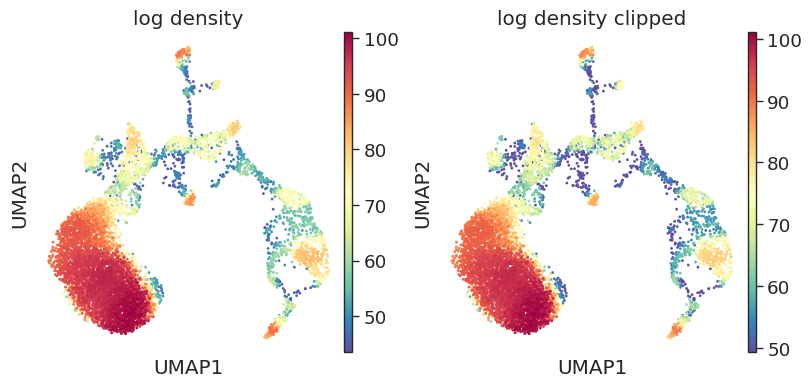

In [19]:
matplotlib.rcParams["figure.figsize"] = [4, 4]
ad.obs["log_density"] = log_density
ad.obs["log_density_clipped"] = np.clip(
    log_density, *np.quantile(log_density, [0.05, 1])
)
sc.pl.scatter(ad, color=["log_density", "log_density_clipped"], basis="umap")

# Stages API

Instead of fitting the model with the fit function, you may split training into
three stages: prepare_inference, run_inference, and process_inference.

In [20]:
model = mellon.DensityEstimator()
model.prepare_inference(X)
model.run_inference()
log_density_x = model.process_inference()

[2023-05-22 01:23:36,538] [INFO    ] Computing nearest neighbor distances.
[2023-05-22 01:23:36,591] [INFO    ] Using covariance function Matern52(ls=0.002264451182505261).
[2023-05-22 01:23:36,591] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2023-05-22 01:23:39,387] [INFO    ] Doing low-rank Cholesky decomposition.
[2023-05-22 01:23:42,661] [INFO    ] Using rank 5,000 covariance representation.
[2023-05-22 01:23:43,498] [INFO    ] Running inference using L-BFGS-B.
[2023-05-22 01:23:54,092] [INFO    ] Computing predictive function.


This allows you to make intermediate changes. For example, if you would like
to use your own optimizer, use the I/O of the three stages and replace
run_inference with your own optimizer:
```python
def optimize(loss_func, initial_parameters):
    ...
    return optimal_parameters

model = mellon.DensityEstimator()
loss_func, initial_parameters = model.prepare_inference(X)
pre_transformation = optimize(loss_func, initial_parameters)
log_density_x = model.process_inference(pre_transformation=pre_transformation)
```

# Derivatives

After inference the density and its derivatives can be computed for arbitrary cell-states.

In [21]:
Y = np.random.rand(100, 10)  # arbitrary cell states

predictor = model.predict
# or
predictor = mellon.Predictor.from_dict(ad.uns["log_density_function"])

log_density = predictor(Y)
gradients = predictor.gradient(Y)
hessians = predictor.hessian(Y)

Of course this also works for Y=X.